In [1]:
%load_ext autoreload
%autoreload 2

# BERT training

In this notebook we will explore training BERT on the IMDB movie rating dataset. We will then try to extract the learned representation for each comment.

In [2]:
import os
import time

from multiprocessing import Pool

In [3]:
os.chdir('../')

In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm.notebook as tnb
import matplotlib.pyplot as plt

from scipy.stats import describe
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup

/home/gio/.virtualenvs/subclass/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gio/.virtualenvs/subclass/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gio/.virtualenvs/subclass/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gio/.virtualenvs/subclass/lib/python3.7/site-pack

In [5]:
from subclass_avail.target_nlp import bert_utils

## Constants

In [6]:
model_id = 'bert-base-uncased'

data_path = '/media/gio/storage/data/imbd_reviews/aclImdb/labeled_data.csv'

seed = 42
n_cores = 8

## Setup

In [7]:
# Get device id
device = bert_utils.get_device()

# Seed all the PRNGs
bert_utils.set_seed(device, seed=seed)

Available device:  cuda


## Data

In [8]:
imdb_df_raw = pd.read_csv(data_path)
imdb_df_train = imdb_df_raw[imdb_df_raw['set'] == 'train']
imdb_df_test = imdb_df_raw[imdb_df_raw['set'] == 'test']

In [9]:
imdb_df_train

,id,set,class,comment_text,score
0,3261,train,1,Nay Sayers of this film are likely bitter from...,9
1,8907,train,1,I saw this movie at midnight on On Demand the ...,8
2,12059,train,1,"I love ghost stories in general, but I PARTICU...",9
3,5284,train,1,Father and son communicate very little. IN fac...,9
4,11807,train,1,After seeing Dick Tracy in the 6.99$ bin at Fu...,7
...,...,...,...,...,...
24995,76,train,0,I saw this at the premiere in Melbourne<br /><...,3
24996,10184,train,0,For months I've been hearing about this little...,1
24997,10678,train,0,"This movie looked good - good cast, evergreen ...",4
24998,12474,train,0,"I saw the MST3K version of ""Deathstalker III"" ...",2


In [10]:
imdb_df_test

,id,set,class,comment_text,score
25000,4249,test,1,"Sure, the film is full of black militant stere...",7
25001,8470,test,1,The very first talking picture has returned fr...,10
25002,5990,test,1,This movie came out about the same time as Pre...,10
25003,8506,test,1,I like both this version of DORIAN GRAY and th...,10
25004,11230,test,1,"""It all depends on how you look at it we are ...",8
...,...,...,...,...,...
49995,6924,test,0,Owen (David Krumholtz) and Chloe (Denise Richa...,1
49996,6361,test,0,Basically the first two Critters movie were al...,4
49997,10184,test,0,Movies about U.F.O.'s are always a nice way to...,1
49998,7081,test,0,"As a documentary, this is laughable in a campy...",4


## Preprocessing

### Tokenization and statistics

We are particularly interested in getting a rough estimate of the average number of words/tokens in a comment. This will impact the training batch size.

In [11]:
train_def, train_adv, test = bert_utils.load_split_tokenized_data()

Tokenized data not found. Generating it now.
Tokenizing data
Tokenization took 72.69 seconds
Tokenization took 72.55 seconds
Splitting data sets for training.


In [12]:
train_def_ds, train_def_dl, test_ds, test_dl = bert_utils.get_data_loaders(
    train_df=train_def,
    test_df=test,
    batch_size=4,
    shuffle=False
)
train_adv_ds, train_adv_dl, test_ds, test_dl = bert_utils.get_data_loaders(
    train_df=train_adv,
    test_df=test,
    batch_size=4,
    shuffle=False
)

Data shapes:
ids_train: 12500
att_train: 12500
y_train: 12500
ids_test: 25000
att_test: 25000
y_test: 25000
Tensors shapes:
ids_train: torch.Size([12500, 256])
att_train: torch.Size([12500, 256])
y_train: torch.Size([12500])
ids_test: torch.Size([25000, 256])
att_test: torch.Size([25000, 256])
y_test: torch.Size([25000])
Data shapes:
ids_train: 12500
att_train: 12500
y_train: 12500
ids_test: 25000
att_test: 25000
y_test: 25000
Tensors shapes:
ids_train: torch.Size([12500, 256])
att_train: torch.Size([12500, 256])
y_train: torch.Size([12500])
ids_test: torch.Size([25000, 256])
att_test: torch.Size([25000, 256])
y_test: torch.Size([25000])


## BERT

### Training loop

In [13]:
tot_steps = len(train_def_dl) * 4

In [14]:
model, optimizer, train_lossses, train_accuracies = bert_utils.train_bert(
    model_id=model_id, 
    device=device,
    train_dl=train_def_dl,
    lr=1e-5, 
    tot_steps=tot_steps, 
    epochs=4,
    save='frozen_bert_classifier', 
    frozen=True
)

  0%|          | 2/3125 [00:00<03:01, 17.19it/s]

Epoch 0 of 4


100%|██████████| 3125/3125 [02:32<00:00, 20.49it/s]


Train loss at epoch 0: 0.38587414804697034


  0%|          | 3/3125 [00:00<02:34, 20.16it/s]

Training accuracy - epoch 0: 0.89272
Epoch 1 of 4


100%|██████████| 3125/3125 [02:35<00:00, 20.08it/s]


Train loss at epoch 1: 0.2832312848043442


  0%|          | 3/3125 [00:00<02:35, 20.05it/s]

Training accuracy - epoch 1: 0.90208
Epoch 2 of 4


100%|██████████| 3125/3125 [02:35<00:00, 20.05it/s]


Train loss at epoch 2: 0.26440433567047117


  0%|          | 2/3125 [00:00<02:36, 20.00it/s]

Training accuracy - epoch 2: 0.90704
Epoch 3 of 4


100%|██████████| 3125/3125 [02:35<00:00, 20.05it/s]


Train loss at epoch 3: 0.2539102554392815
Training accuracy - epoch 3: 0.90832


### Results

#### Training

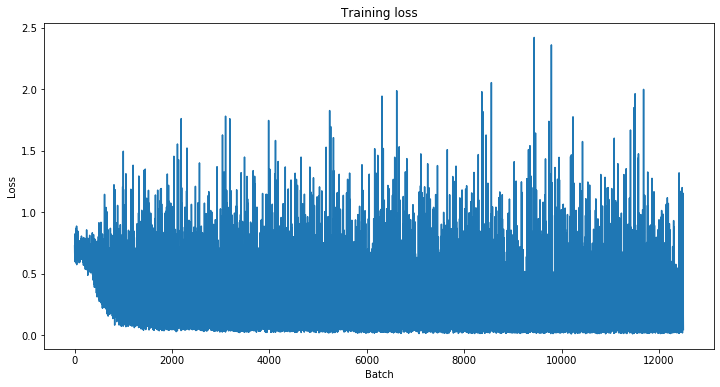

In [15]:
bert_utils.visualize_losses(train_lossses)

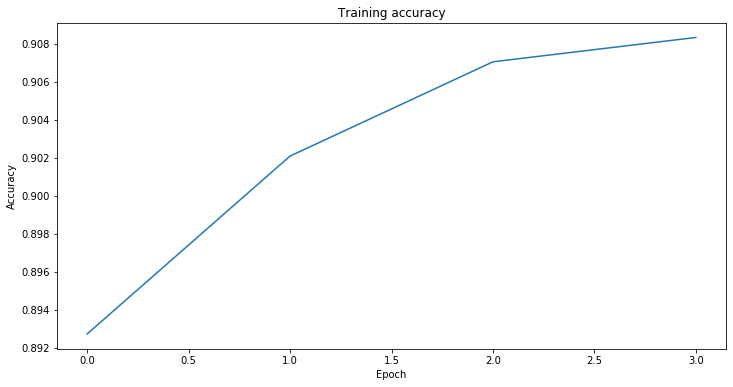

In [16]:
bert_utils.visualize_accuracies(train_accuracies)

#### Testing

In [17]:
prediction = bert_utils.predict_bert(model, device, test_dl=test_dl)

100%|██████████| 6250/6250 [04:18<00:00, 24.15it/s]


In [18]:
y_test = test_ds.tensors[2].numpy()
print(y_test.shape)

(25000,)


In [19]:
y_test

array([1, 1, 1, ..., 0, 0, 0])

In [20]:
cm, cr = bert_utils.eval_classification(prediction, y_test)

              precision    recall  f1-score   support

           0   0.900366  0.884880  0.892556     12500
           1   0.886827  0.902080  0.894388     12500

    accuracy                       0.893480     25000
   macro avg   0.893596  0.893480  0.893472     25000
weighted avg   0.893596  0.893480  0.893472     25000

[[11061  1439]
 [ 1224 11276]]


In [21]:
for name, param in model.named_parameters():
    if 'classifier' not in name:  # classifier layer
#         param.requires_grad = False
        print(name)
        print(param.requires_grad)
    else:
        print('------------', name)
        print(param.data.shape)
        print(param.requires_grad)
        print('------------')

bert.embeddings.word_embeddings.weight
False
bert.embeddings.position_embeddings.weight
False
bert.embeddings.token_type_embeddings.weight
False
bert.embeddings.LayerNorm.weight
False
bert.embeddings.LayerNorm.bias
False
bert.encoder.layer.0.attention.self.query.weight
False
bert.encoder.layer.0.attention.self.query.bias
False
bert.encoder.layer.0.attention.self.key.weight
False
bert.encoder.layer.0.attention.self.key.bias
False
bert.encoder.layer.0.attention.self.value.weight
False
bert.encoder.layer.0.attention.self.value.bias
False
bert.encoder.layer.0.attention.output.dense.weight
False
bert.encoder.layer.0.attention.output.dense.bias
False
bert.encoder.layer.0.attention.output.LayerNorm.weight
False
bert.encoder.layer.0.attention.output.LayerNorm.bias
False
bert.encoder.layer.0.intermediate.dense.weight
False
bert.encoder.layer.0.intermediate.dense.bias
False
bert.encoder.layer.0.output.dense.weight
False
bert.encoder.layer.0.output.dense.bias
False
bert.encoder.layer.0.output.Lay

In [22]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
torch.save(model.state_dict(), 'new_frozen_bert.ckpt') 